In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../images/style_sheet.mplstyle')
import seaborn as sns
from scipy.stats import beta

from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay

import os
import sys
sys.path.append(os.path.join(os.path.abspath(''), '..'))
from utils.transformer import WaveletTransformer
from utils.kernels import generalized_cone_kernel

In [2]:
X_train = np.load('../data/X_train.npy')
y_train = np.load('../data/y_train.npy')
groups_train = np.load('../data/groups_train.npy')
severities_train = np.load('../data/severities_train.npy')

In [3]:
def create_kernel(gamma, beta):
    def kernel(X, Y):
        return generalized_cone_kernel(X, Y, gamma, beta)
    return kernel

pipeline = Pipeline([
    ('wavelet_transformer', WaveletTransformer(w_list=[83, 130, 1435], n_samples=100, n_frequencies=20)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=12)),
    ('svm', SVC(probability=True, kernel=create_kernel(0.7686, 6.190), C=50))
])

pipeline.fit(X_train, y_train);

In [4]:
y_pred_train = pipeline.predict(X_train)
y_pred_proba_train = pipeline.predict_proba(X_train)

In [5]:
X_test = np.load('../data/X_test.npy')
y_test = np.load('../data/y_test.npy')
groups_test = np.load('../data/groups_test.npy')
severities_test = np.load('../data/severities_test.npy')

In [6]:
y_pred_test = pipeline.predict(X_test)
y_pred_proba_test = pipeline.predict_proba(X_test)

Accuracy: 90.70%
AUC ROC: 0.97


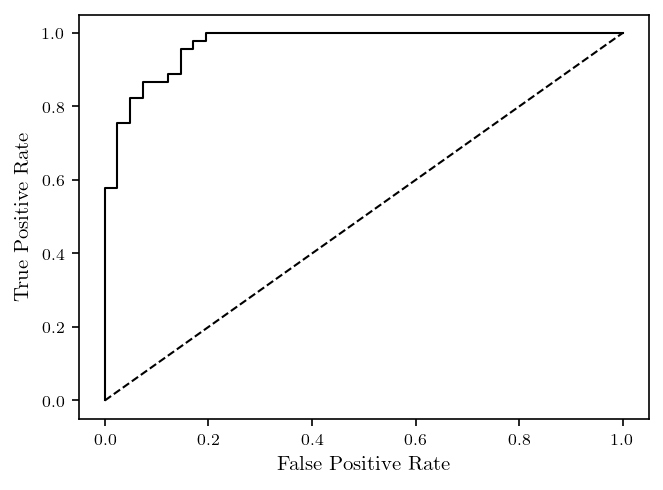

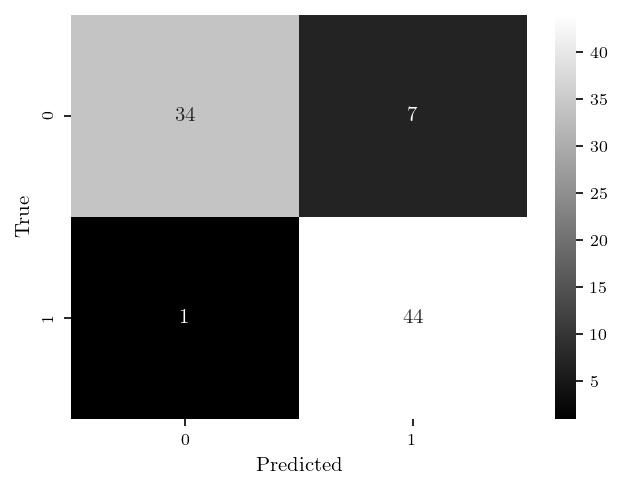

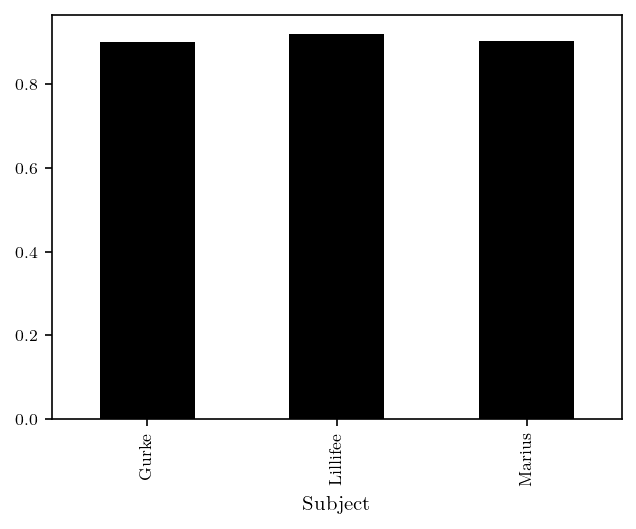

In [7]:
accuracy = np.mean(y_pred_test == y_test)
print(f'Accuracy: {accuracy:.2%}')

auc_roc = roc_auc_score(y_test, y_pred_proba_test[:, 1])
print(f'AUC ROC: {auc_roc:.2f}')

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test[:, 1])
plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, cmap='grey')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

df = pd.DataFrame({'y': y_test, 'y_pred': y_pred_test, 'Subject': groups_test})
df['correct'] = df['y'] == df['y_pred']
df.groupby('Subject').mean()['correct'].plot(kind='bar', color='black');

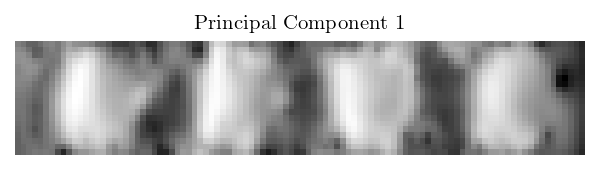

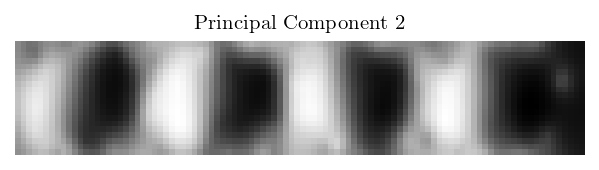

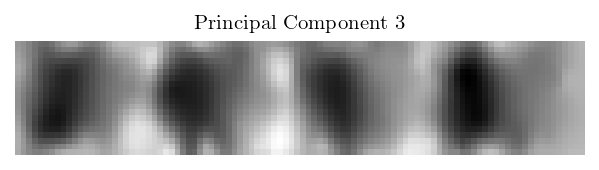

In [8]:
pca = pipeline.named_steps['pca']

for idx in range(3):
    pc = pca.components_[idx]
    pc = np.moveaxis(pc.reshape(-1, 20, 100), 0, -1)
    plt.imshow(pc[:,:,0], cmap='gray')
    plt.title(f'Principal Component {idx+1}')
    plt.axis('off')
    plt.savefig(f'../images/pca_{idx+1}.pdf', format='pdf', bbox_inches='tight')
    plt.show()

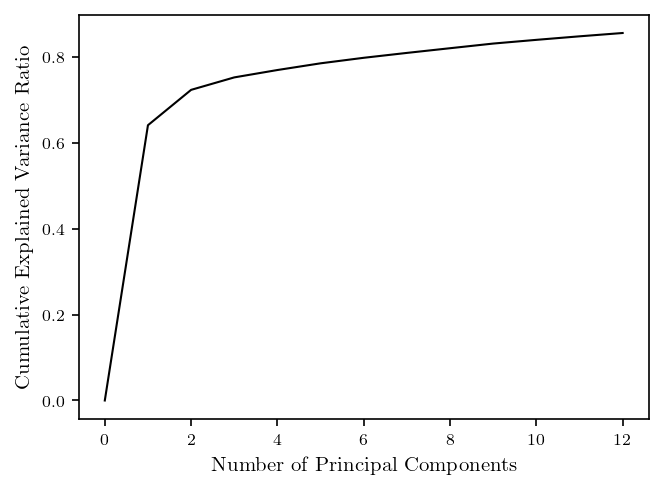

In [9]:
cumulative_explained_variance_ratio = np.concatenate((np.zeros(1), pca.explained_variance_ratio_)).cumsum()
num_components = len(cumulative_explained_variance_ratio)
plt.plot(range(0, num_components), cumulative_explained_variance_ratio, color='black')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

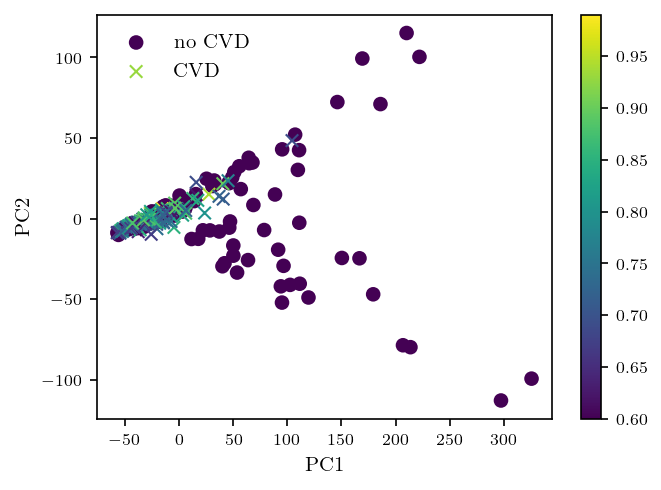

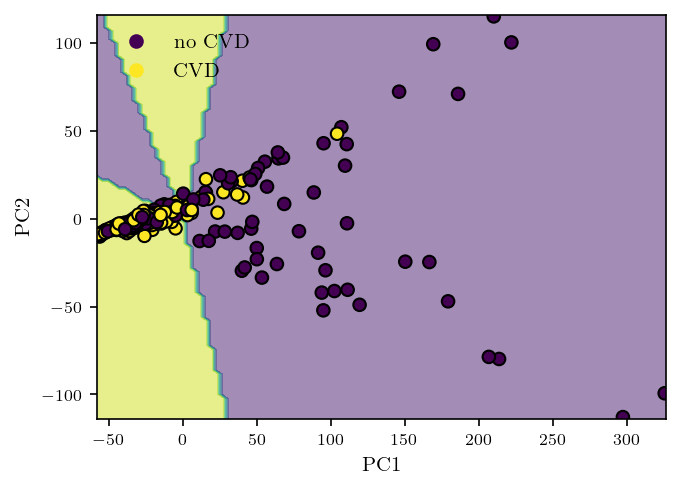

In [10]:
X_pca = pipeline.named_steps['wavelet_transformer'].transform(X_train)
X_pca = pipeline.named_steps['scaler'].transform(X_pca)
X_pca = pipeline.named_steps['pca'].transform(X_pca)

markers = ['o', 'x']
for i, marker in enumerate(markers):
    plt.scatter(X_pca[y_train == i, 0], X_pca[y_train == i, 1], marker=marker, label='CVD' if i == 1 else 'no CVD', c=np.array(severities_train)[y_train == i])

plt.legend()
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

X_reduced = X_pca[:,:2]

model = clone(pipeline.named_steps['svm'])

model.fit(X_reduced, y_train)
disp = DecisionBoundaryDisplay.from_estimator(
    model, X_reduced, response_method="predict",
    xlabel='PC1', ylabel='PC2',
    alpha=0.5,
)
scatter = disp.ax_.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train, edgecolors='k', cmap='viridis')
disp.ax_.legend(handles=scatter.legend_elements()[0], labels=['no CVD', 'CVD'])
plt.show()

In [11]:
X_cvd = np.load('../data/X_cvd.npy')
y_cvd = np.load('../data/y_cvd.npy')
groups_cvd = np.load('../data/groups_cvd.npy')

X_cvd = X_cvd[y_cvd == 0]
groups_cvd = groups_cvd[y_cvd == 0]
y_cvd = np.abs(y_cvd[y_cvd == 0] - 1)

In [12]:
y_pred_cvd = pipeline.predict(X_cvd)
y_pred_proba_cvd = pipeline.predict_proba(X_cvd)

Accuracy: 82.05%


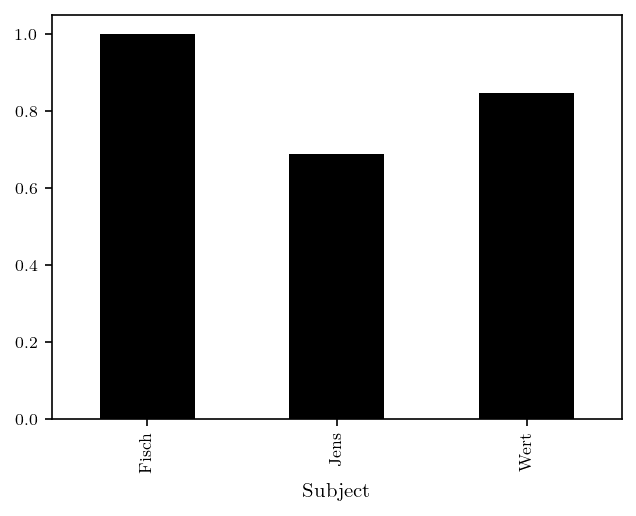

In [13]:
accuracy = np.mean(y_pred_cvd == y_cvd)
print(f'Accuracy: {accuracy:.2%}')

df = pd.DataFrame({'y': y_cvd, 'y_pred': y_pred_cvd, 'Subject': groups_cvd})
df['correct'] = df['y'] == df['y_pred']
df.groupby('Subject').mean()['correct'].plot(kind='bar', color='black');

In [14]:
y_pred_no_cvd =  y_pred_test[y_test == 0]
y_pred_proba_no_cvd = y_pred_proba_test[y_test == 0]

y_combined = np.concatenate((np.ones(y_pred_cvd.shape[0]), np.zeros(y_pred_no_cvd.shape[0])))
y_pred_combined = np.concatenate((y_pred_cvd, y_pred_no_cvd))
y_pred_proba_combined = np.concatenate((y_pred_proba_cvd[:, 1], y_pred_proba_no_cvd[:, 1]))

Accuracy: 82.50%
Recall: 82.05%
Precision: 82.05%
F1: 82.05%
AUC ROC: 90.43%


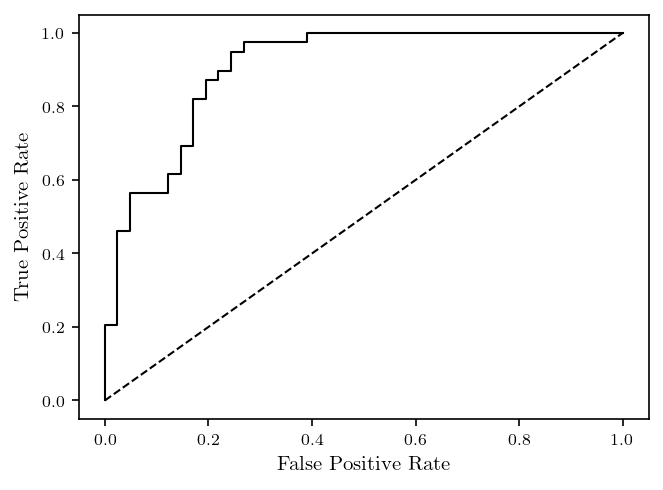

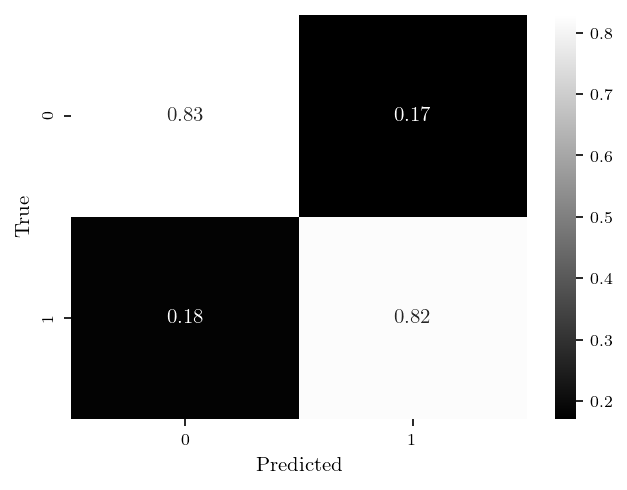

In [15]:
accuracy = np.mean(y_pred_combined == y_combined)
print(f'Accuracy: {accuracy:.2%}')

recall = np.sum(np.logical_and(y_combined, y_pred_combined)) / np.sum(y_combined)
print(f'Recall: {recall:.2%}')

precision = np.sum(np.logical_and(y_combined, y_pred_combined)) / np.sum(y_pred_combined)
print(f'Precision: {precision:.2%}')

f1 = 2 * precision * recall / (precision + recall)
print(f'F1: {f1:.2%}')

auc_roc = roc_auc_score(y_combined, y_pred_proba_combined)
print(f'AUC ROC: {auc_roc:.2%}')

fpr, tpr, thresholds = roc_curve(y_combined, y_pred_proba_combined)
plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('../images/roc.pdf', format='pdf')
plt.show()

conf_matrix = confusion_matrix(y_combined, y_pred_combined, normalize='true')
sns.heatmap(conf_matrix, annot=True, cmap='grey')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('../images/confusion_matrix.pdf', format='pdf')
plt.show()

Not Simulated
a: 0.2703531318609362, b: 1.107349945506148


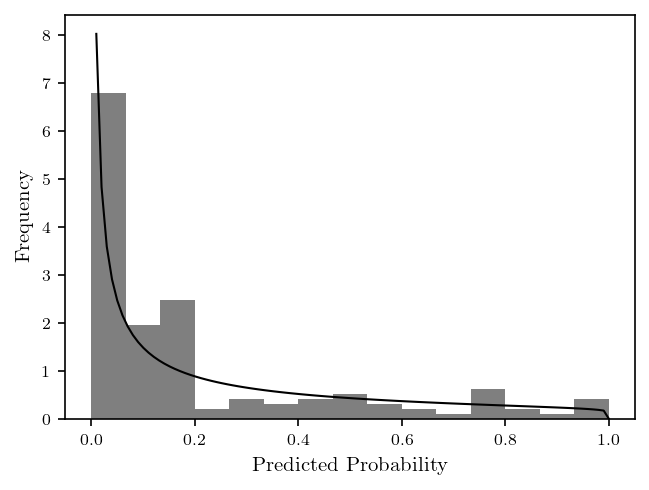

Simulated
a: 1.9092784478383147, b: 0.40775603990739084


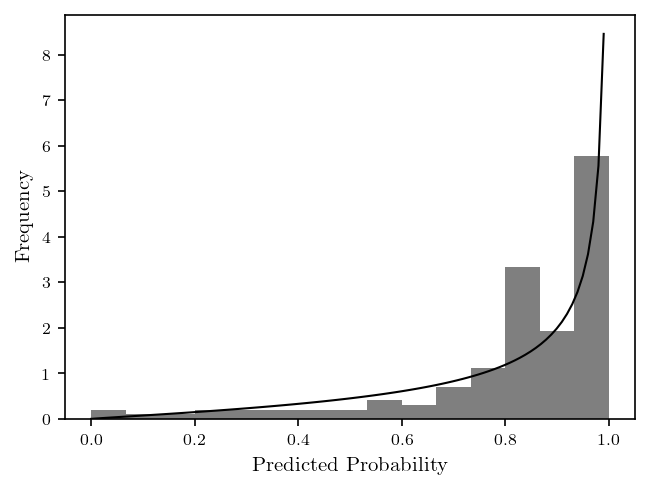

CVD


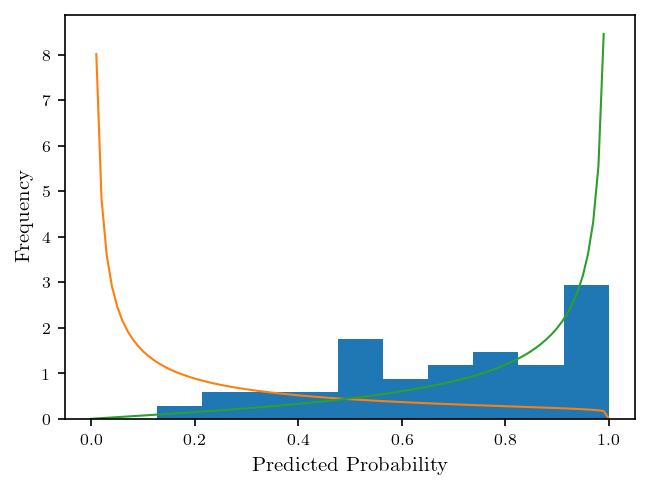

In [16]:
simulated = y_pred_proba_train[y_train == 1][:, 1]
not_simulated = y_pred_proba_train[y_train == 0][:, 1]

simulated = np.concatenate((simulated, np.linspace(0, 1, 20)))
not_simulated = np.concatenate((not_simulated, np.linspace(0, 1, 20)))

mu_not_simulated = np.mean(not_simulated)
sigma_not_simulated = np.std(not_simulated)
a_not_simulated = mu_not_simulated*(mu_not_simulated*(1-mu_not_simulated)/sigma_not_simulated**2 - 1)
b_not_simulated = (1-mu_not_simulated)*(mu_not_simulated*(1-mu_not_simulated)/sigma_not_simulated**2 - 1)

mu_simulated = np.mean(simulated)
sigma_simulated = np.std(simulated)
a_simulated = mu_simulated*(mu_simulated*(1-mu_simulated)/sigma_simulated**2 - 1)
b_simulated = (1-mu_simulated)*(mu_simulated*(1-mu_simulated)/sigma_simulated**2 - 1)

print('Not Simulated')
print(f'a: {a_not_simulated}, b: {b_not_simulated}')
plt.hist(not_simulated, density=True, color='black', bins=15, alpha=0.5)
plt.plot(np.linspace(0, 1, 100), beta.pdf(np.linspace(0, 1, 100), a_not_simulated, b_not_simulated), color='black')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.savefig('../images/beta.pdf', format='pdf')
plt.show()

print('Simulated')
print(f'a: {a_simulated}, b: {b_simulated}')
plt.hist(simulated, density=True, color='black', bins=15, alpha=0.5)
plt.plot(np.linspace(0, 1, 100), beta.pdf(np.linspace(0, 1, 100), a_simulated, b_simulated), color='black')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.savefig('../images/beta_cvd.pdf', format='pdf')
plt.show()

print('CVD')
plt.hist(y_pred_proba_cvd[:, 1], density=True)
plt.plot(np.linspace(0, 1, 100), beta.pdf(np.linspace(0, 1, 100), a_not_simulated, b_not_simulated))
plt.plot(np.linspace(0, 1, 100), beta.pdf(np.linspace(0, 1, 100), a_simulated, b_simulated))
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

In [17]:
likelihood_ratios = []
for _ in range(1000000):
    y_group_pred_proba = np.random.choice(not_simulated, 10)
    log_likelihood_cvd = np.sum(beta.logpdf(y_group_pred_proba, a_simulated, b_simulated))
    log_likelihood_no_cvd = np.sum(beta.logpdf(y_group_pred_proba, a_not_simulated, b_not_simulated))
    likelihood_ratio = np.exp(log_likelihood_cvd - log_likelihood_no_cvd)
    if not np.isinf(likelihood_ratio):
        likelihood_ratios.append(likelihood_ratio)

min(likelihood_ratios), max(likelihood_ratios)

/home/tim/miniconda3/envs/p11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(0.0, 3144.9812566969117)

Subject: Marius, Accuracy: 86.67%
Log Likelihood No CVD: 29.653751084899923
Log Likelihood CVD: -68.09662960905914
Likelihood Ratio: 3.5281664078316107e-43
No CVD
p-value: 0.926548055156699


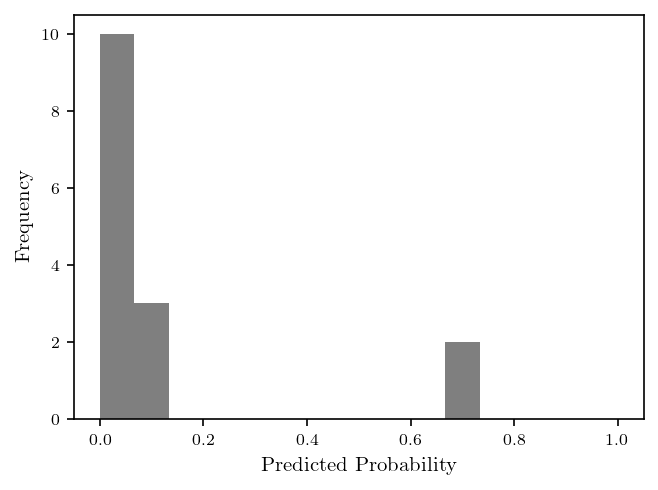

Subject: Gurke, Accuracy: 80.00%
Log Likelihood No CVD: 7.571202584387959
Log Likelihood CVD: -39.38714712516557
Likelihood Ratio: 4.038758098367688e-21
No CVD
p-value: 0.5834647248459038


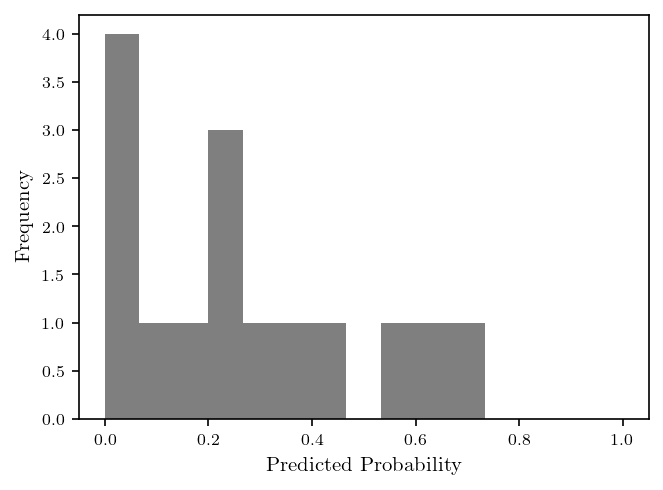

Subject: Lillifee, Accuracy: 81.82%
Log Likelihood No CVD: 4.99892453380985
Log Likelihood CVD: -27.826792345648247
Likelihood Ratio: 5.545903324407027e-15
No CVD
p-value: 0.26222154422542304


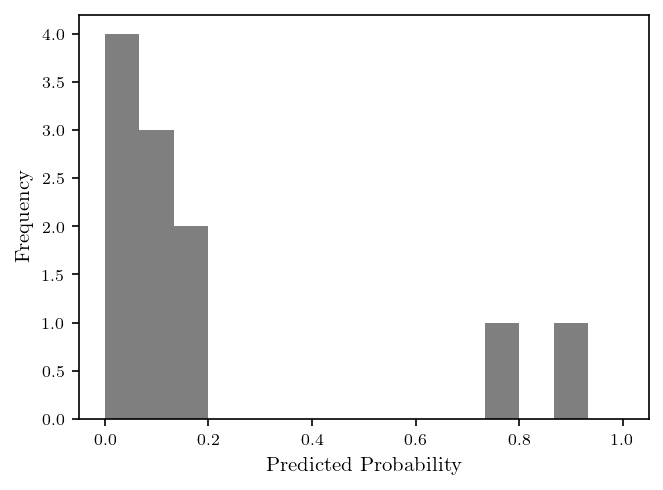

Subject: Wert, Accuracy: 84.62%
Log Likelihood No CVD: -12.627110786265646
Log Likelihood CVD: -6.194988300498078
Likelihood Ratio: 621.4916563046505
CVD
p-value: 3.2003345416374193e-06


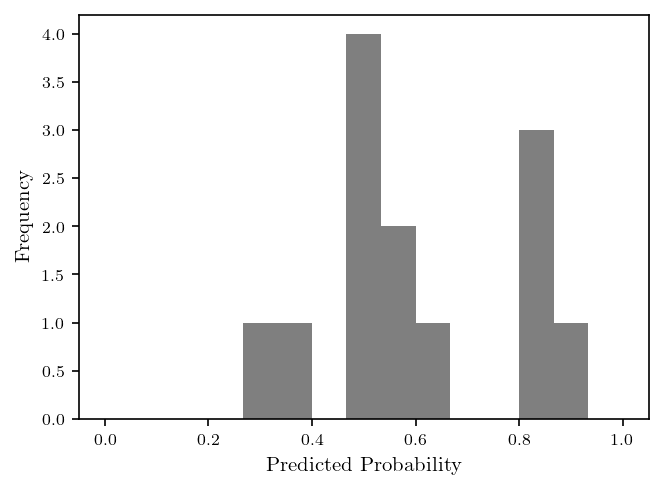

Subject: Jens, Accuracy: 68.75%
Log Likelihood No CVD: -14.70706579802969
Log Likelihood CVD: -8.562644265089645
Likelihood Ratio: 466.10994181457215
CVD
p-value: 3.2003345416374193e-06


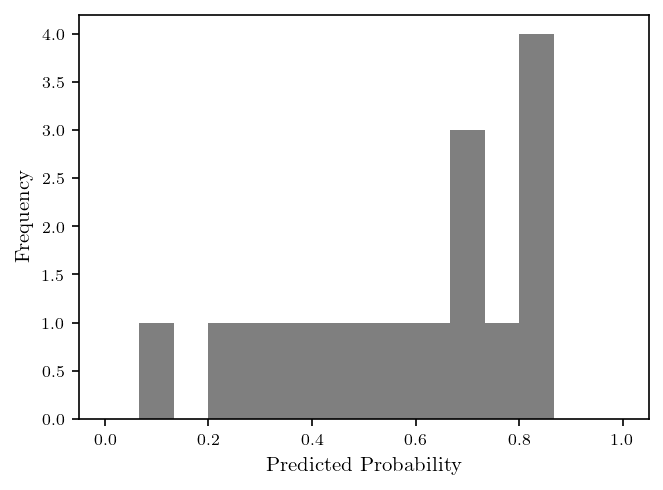

Subject: Fisch, Accuracy: 100.00%
Log Likelihood No CVD: -27.86620828639124
Log Likelihood CVD: 78.59993904682575
Likelihood Ratio: 1.7284638317083804e+46
CVD
p-value: 0.0


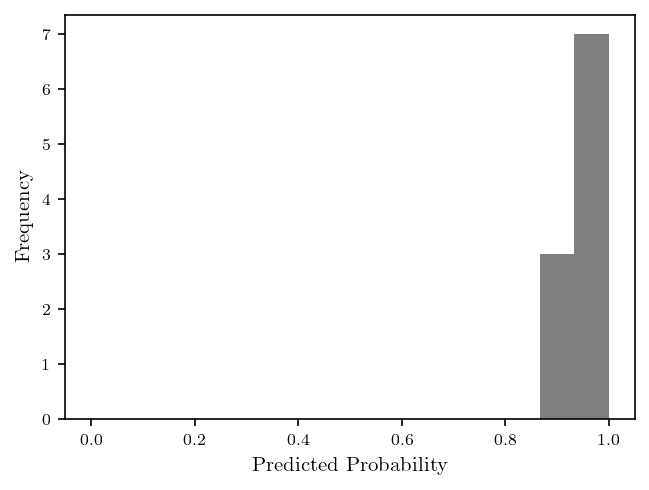

In [18]:
for group in set(groups_test):
    y_group_pred = y_pred_test[np.logical_and(groups_test == group, y_test == 0)]
    y_group_pred_proba = y_pred_proba_test[np.logical_and(groups_test == group, y_test == 0)]
    print(f'Subject: {group}, Accuracy: {np.mean(y_group_pred == 0):.2%}')
    log_likelihood_no_cvd = np.sum(beta.logpdf(y_group_pred_proba[:, 1], a_not_simulated, b_not_simulated))
    log_likelihood_cvd = np.sum(beta.logpdf(y_group_pred_proba[:, 1], a_simulated, b_simulated))
    likelihood_ratio = np.exp(log_likelihood_cvd - log_likelihood_no_cvd)
    print(f'Log Likelihood No CVD: {log_likelihood_no_cvd}')
    print(f'Log Likelihood CVD: {log_likelihood_cvd}')
    print(f'Likelihood Ratio: {likelihood_ratio}')
    if log_likelihood_no_cvd > log_likelihood_cvd:
        print('No CVD')
    else:
        print('CVD')
    
    p_value = np.mean(np.array(likelihood_ratios) > likelihood_ratio)
    print(f'p-value: {p_value}')
    plt.hist(y_group_pred_proba[:, 1], range=(0, 1), color='black', bins=15, alpha=0.5)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.savefig(f'../images/predictions_{group}.pdf', format='pdf')
    plt.show()

for group in set(groups_cvd):
    y_group_pred = y_pred_cvd[groups_cvd == group]
    y_group_pred_proba = y_pred_proba_cvd[groups_cvd == group]
    print(f'Subject: {group}, Accuracy: {np.mean(y_group_pred):.2%}')
    log_likelihood_no_cvd = np.sum(beta.logpdf(y_group_pred_proba[:, 1], a_not_simulated, b_not_simulated))
    log_likelihood_cvd = np.sum(beta.logpdf(y_group_pred_proba[:, 1], a_simulated, b_simulated))
    likelihood_ratio = np.exp(log_likelihood_cvd - log_likelihood_no_cvd)
    print(f'Log Likelihood No CVD: {log_likelihood_no_cvd}')
    print(f'Log Likelihood CVD: {log_likelihood_cvd}')
    print(f'Likelihood Ratio: {likelihood_ratio}')
    if log_likelihood_no_cvd > log_likelihood_cvd:
        print('No CVD')
    else:
        print('CVD')

    p_value = np.mean(np.array(likelihood_ratios) > likelihood_ratio)
    print(f'p-value: {p_value}')
    plt.hist(y_group_pred_proba[:, 1], range=(0, 1), color='black', bins=15, alpha=0.5)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.savefig(f'../images/predictions_{group}.pdf', format='pdf')
    plt.show()